# 02477 Bayesian Machine Learning - Exercise 4

Rev. 1.01 (25/2/26): Fixed wrong sign in gradient calculation for logistic regression, and minor bug in LaplaceApproximation1D class

In [1]:
%matplotlib inline
import jax.numpy as jnp
import jax
import numpy as onp
from jax import random
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as snb

from scipy.optimize import minimize

from scipy.stats import multivariate_normal as mvn
from scipy.stats import beta as beta_dist
from scipy.stats import binom as binom_dist
from scipy.stats import norm as norm_dist

from mpl_toolkits.axes_grid1 import make_axes_locatable

snb.set_style('darkgrid')
snb.set_theme(font_scale=1.)

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

jax.config.update("jax_enable_x64", True)

# Introduction

In this exercise, we will work with probabilistic methods for classification. We will focus on **binary** classification, but everything we discuss can fairly easily be extended to **multi-class** classification. For binary classification we typically observe a dataset $\mathcal{D} = \left\lbrace (\mathbf{x}_n, y_n) \right\rbrace_{n=1}^N$, where $\mathbf{x}_n \in \mathbb{R}^D$ and $y_n \in \left\lbrace 0, 1 \right\rbrace$ are assumed to be input features and label for the $n$'th observation, respectively. Our goal is to use the dataset $\mathcal{D}$ to reason about a new data point $\mathbf{x}^* \in \mathbb{R}^D$ and its associated label $y^* \in \left\lbrace 0, 1\right\rbrace$.

We will study two different approaches: the **generative** and the **discriminative** approach. In the former we model the **joint distribution of inputs and outputs**, i.e. $p(\mathbf{x}, y)$, whereas in the latter we only model the **conditional distribution of the output conditioned on the input**, i.e. $p(y|\mathbf{x})$. That is, for generative classification we make assumptions on the distribution of the inputs $p(\mathbf{x})$, either implicitly or explicitly, whereas for discriminative classification we only make assumptions about the distribution of the different outcomes given the specific input. 

We will also study the Laplace approximation as a computational tool for approximating the posterior distribution of the parameters of a probabilistic model. First, we will study the properties of the Laplace approximation using a model we also know, the beta-binomial model. Afterwards, we will apply the Laplace approximation to the logistic regression model.


**Content**

- Part 1: Implementing a simple generative classifier
- Part 2: Understanding the Laplace approximations
- Part 3: Implementing the logistic regression model
- Part 4: Implementing the Laplace approximation for logistic regression
- Part 5: Approximating the posterior predictive distribution
- Part 6: Insights into the posterior predictive distribution via the probit approximation



**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

We will be working with the MNIST dataset (more information here: http://yann.lecun.com/exdb/mnist/), which consists of digital images of digits from 0-9. Each image is 28x28 pixels and is represented in a vectorized manner such that each image is represented as a vector in $\mathbb{R}^{784}$. Specifically, we will build classifiers for distinguishing between 8s (encoded as $y=0$) and 9s (encoded as $y=1$), a binary classification problem. In order to visualize the resulting dataset, we use **principal component analysis** (PCA) to reduce the dimensionality to $D = 2$. We won't cover PCA in this course, but you can read more about it in Section 20.1 in Murphy1 or in Section 12.1 in the Bishop if you are unfamiliar with it.

The matrices $\textbf{I}_{\text{train}} \in \mathbb{R}^{197 \times 784}$ and $\textbf{X}_{\text{train}} \in \mathbb{R}^{197 \times 2}$ contains the raw pixel values and the low-dimensional PCA representation, respectively. Note that we will use a fairly small training set to make the problem more challenging.


Shape of Itrain: (197, 784)
Shape of Xtrain: (197, 2)
Shape of ytrain: (197,)


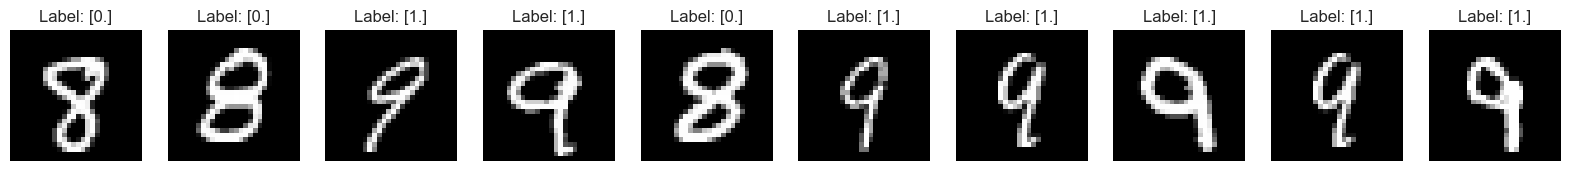

In [2]:
# read data
data = jnp.load('./mnist_subset_89.npz')
Itrain, Itest  = data['Itrain'], data['Itest']
Xtrain, Xtest = data['Xtrain'], data['Xtest']
ytrain, ytest = data['ytrain'], data['ytest']
digits = data['digits']

key = random.PRNGKey(1)
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for idx_plot, i in enumerate(random.choice(key, jnp.arange(len(Xtrain)), shape=(10, 1))):
    ax[idx_plot].imshow(Itrain[i].reshape((28, 28)), cmap=plt.cm.gray)
    ax[idx_plot].set_title(f'Label: {ytrain[i]}') 
    ax[idx_plot].axis('off')

# print shapes of Images (Itrain), feature representations (Xtrain) and labels (ytrain)
print('Shape of Itrain:', Itrain.shape)
print('Shape of Xtrain:', Xtrain.shape)
print('Shape of ytrain:', ytrain.shape)

We will work in the 2-dimensional PCA space in the rest of the exercise for easier visualization, but nothing prevents us from working on the original data space. 

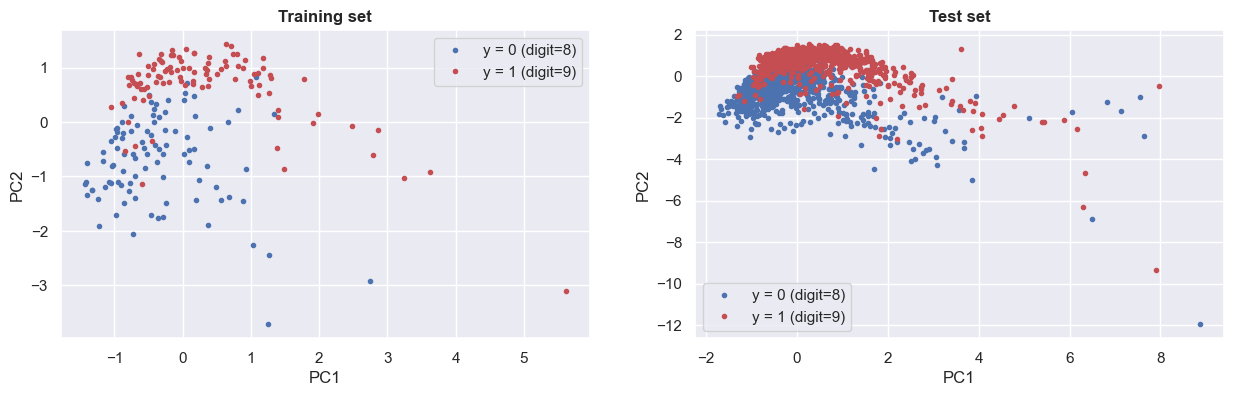

In [3]:
def plot_data(ax, X, y, alpha=0.8, title=None):

    ax.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], 'b.', label='y = 0 (digit=8)')
    ax.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], 'r.', label='y = 1 (digit=9)')
    ax.set(xlabel='PC1', ylabel='PC2')
    ax.legend()
    

    if title:
        ax.set_title(title, fontweight='bold')

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
plot_data(ax[0], Xtrain, ytrain, title='Training set')
plot_data(ax[1], Xtest, ytest, title='Test set')

# Part 1:  Implementing a simple generative classifier

In the first part of the exercise, we will study a simple **generative classifier** given by

$$\begin{align*}
p(y = k | \textbf{x}) = \frac{p(\textbf{x}|y=k)p(y=k)}{p(\textbf{x})},
\end{align*}$$

where
- $k$ can take the values $0$ or $1$ since we are dealing with binary classification
- $p(y = k | \textbf{x})$ the posterior probability that the observation $y$ belongs to class $k$ given the input point $\textbf{x}$
- $p(\textbf{x}|y=k)$ is the class-conditional distribution for class $k$
- $p(y=k)$ is the prior class probability for the $k$'th class
- $p(\textbf{x})$ is the marginal density of the data

The **prior probability**, $p(y=k)$ of an observation belonging to class $k$ is given by $p(y=k)=\pi_k \in \left[0,1\right]$ and satisfies $\sum_{k} \pi_k = 1$.

For the **class-conditional distributions** we will **assume** bivariate normal distributions with mean $\mathbf{m}_k$ and covariance matrix $\textbf{S}_k$. That is,
\begin{align*}
p(\textbf{x}|y=k) = \mathcal{N}(\textbf{x}_n|\mathbf{m}_k, \textbf{S}_k).
\end{align*}

We can derive the marginal data distribution $p(\textbf{x})$ via the sum rule by marginalizing out $y$ from $p(\textbf{x}, y)$:

$$
\begin{align*}
p(\textbf{x}) = \sum_{y} p(\textbf{x}, y) = \sum_{y} p(\textbf{x}|y)p(y) =p(y=0)\mathcal{N}(\textbf{x}|\mathbf{m}_0, \textbf{S}_0) + p(y=1)\mathcal{N}(\textbf{x}|\mathbf{m}_1, \textbf{S}_1).
\end{align*}
$$


We can estimate this probability using the training data by estimating the fraction data point belong to each of the classes, e.g.

$$\begin{align*}
\pi_1 = p(y=1) &\approx \frac{\text{number of training point with label 1}}{\text{total number of training points}} = \frac{1}{N} \sum_{n=1}^N y_n.
\end{align*}
$$

We only need to estimate the prior probability for one of the two classes since $p(y=0) = 1 - p(y=1)$.

The posterior distribution $p(y|\textbf{x})$ gives us a number in the unit interval. We can turn this into a classification rule, by classifying an input point $x$ as the class $k$ that maximizes the posterior class probability. That is,

$$
\begin{align*}
\hat{y}_n = \arg\max\limits_{k} p(y_n = k | x_n)
\end{align*}
$$



First, we estimate the prior probability of $p(y=1)$ and $p(y=0)$ using the training data:

In [4]:
pi1 = jnp.mean(ytrain)
pi0 = 1 - pi1

print(f'p(y = 1) = {pi1:4.3f}')
print(f'p(y = 0) = {pi0:4.3f}')

p(y = 1) = 0.513
p(y = 0) = 0.487


Next, we estimate and report the parameters of the class-conditional distributions $p(\mathbf{x}|y=k)$, i.e. $\left\lbrace \textbf{m}_0, \textbf{m}_1, \textbf{S}_0, \textbf{S}_1 \right\rbrace$, using the training data


In [5]:
# estimate parameters for p(x|y=0)
m0 = jnp.mean(Xtrain[ytrain.ravel()==0, :], axis=0)
S0 = jnp.cov(Xtrain[ytrain.ravel()==0, :].T)

# estimate parameters for p(x|y=1)
m1 = jnp.mean(Xtrain[ytrain.ravel()==1, :], axis=0)
S1 = jnp.cov(Xtrain[ytrain.ravel()==1, :].T)     

print('The mean vector m0 is:')
print(onp.array2string(m0, precision=2), '\n')
print('The covariance matrix S0:')
print(onp.array2string(S0, precision=2), '\n\n')


print('The mean vector m1 is:')
print(onp.array2string(m1, precision=2), '\n')
print('The covariance matrix S1:')
print(onp.array2string(S1, precision=2))

The mean vector m0 is:
[-0.36 -0.69] 

The covariance matrix S0:
[[ 0.56 -0.09]
 [-0.09  0.66]] 


The mean vector m1 is:
[0.34 0.66] 

The covariance matrix S1:
[[ 1.19 -0.39]
 [-0.39  0.45]]


We can plot the contours of the two class-conditional distributions superimposed the training data.


In [6]:
def eval_density_grid(density_fun, dim1_array, dim2_array):
    """ evaluates the function density_fun on two 2d grid formed by the values in the two arrays: dim1_array and dim2_array """
    X1, X2 = jnp.meshgrid(dim1_array, dim2_array, indexing='ij')
    XX = jnp.column_stack((X1.ravel(), X2.ravel()))
    return density_fun(XX).reshape((len(dim1_array), len(dim2_array)))

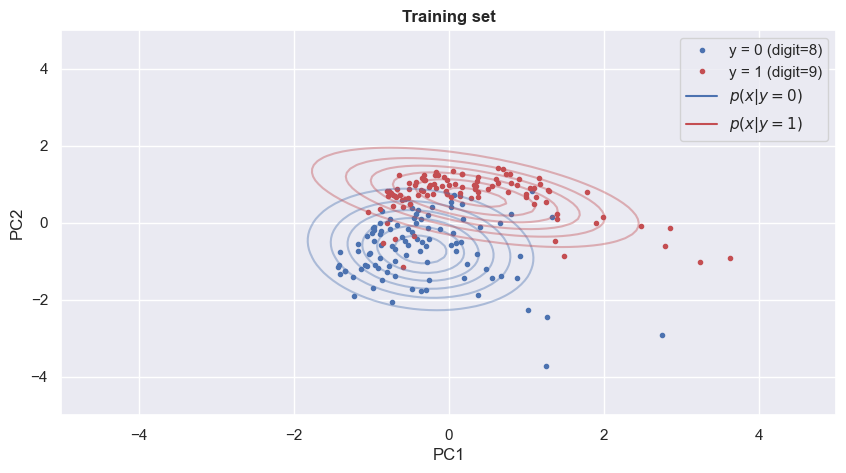

In [ ]:
def plot_distribution(ax, dim1_array, dim2_array, density_fun, color=None, alpha=1, label=None, title=None, num_points = 100):
  
    # evaluate density for every point in the grid and reshape back
    Z = eval_density_grid(density_fun, dim1_array, dim2_array)
    
    # plot contour      
    cs = ax.contour(dim1_array, dim2_array, jnp.exp(Z).T, colors=color, alpha=alpha)

    # hack to add label
    if label:
        ax.plot([-1000, -1000], [-1000, -1000], color=color, label=label)
        ax.set(xlim=[dim1_array[0], dim1_array[-1]], ylim=[dim2_array[0], dim2_array[-1]])


# specify grids for plotting (I usually different different number of points in each dimension to make debugging easier)
dim1_array = jnp.linspace(-5, 5, 100)
dim2_array = jnp.linspace(-5, 5, 101)

# define function evaluating  class-conditionals
log_p_x_given_y0 = lambda x: mvn.logpdf(x, m0, S0)
log_p_x_given_y1 = lambda x: mvn.logpdf(x, m1, S1)

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_data(ax, Xtrain, ytrain, title='Training set')
plot_distribution(ax, dim1_array, dim2_array, log_p_x_given_y0, color='b', alpha=0.4, label='$p(x|y=0)$')
plot_distribution(ax, dim1_array, dim2_array, log_p_x_given_y1, color='r', alpha=0.4, label='$p(x|y=1)$')
ax.legend()

**Task 1.1**: Implement a function for evaluating the posterior distribution $p(y=1|\textbf{x})$ and the marginal data distribution $p(\textbf{x})$

**Solution**

In [8]:
# define function evaluating  class-conditionals
p_x_given_y0 = lambda x: mvn.pdf(x, m0, S0)
p_x_given_y1 = lambda x: mvn.pdf(x, m1, S1)

marginal = lambda x: pi0 * p_x_given_y0(x) + pi1 * p_x_given_y1(x)
log_marginal = lambda x: jnp.log(marginal(x))
posterior_y1 = lambda x: pi1*mvn.pdf(x, m1, S1)/marginal(x)

**End of solution**

**Task 1.2**: Create a plot with three subfigures: 1) plotting the class-conditional data distributions superimposed on the data, 2) plot the marginal data distribution superimposed on the data, and 3) plot the posterior distribution superimposed on the data. Comment on the plots.

**Solution**

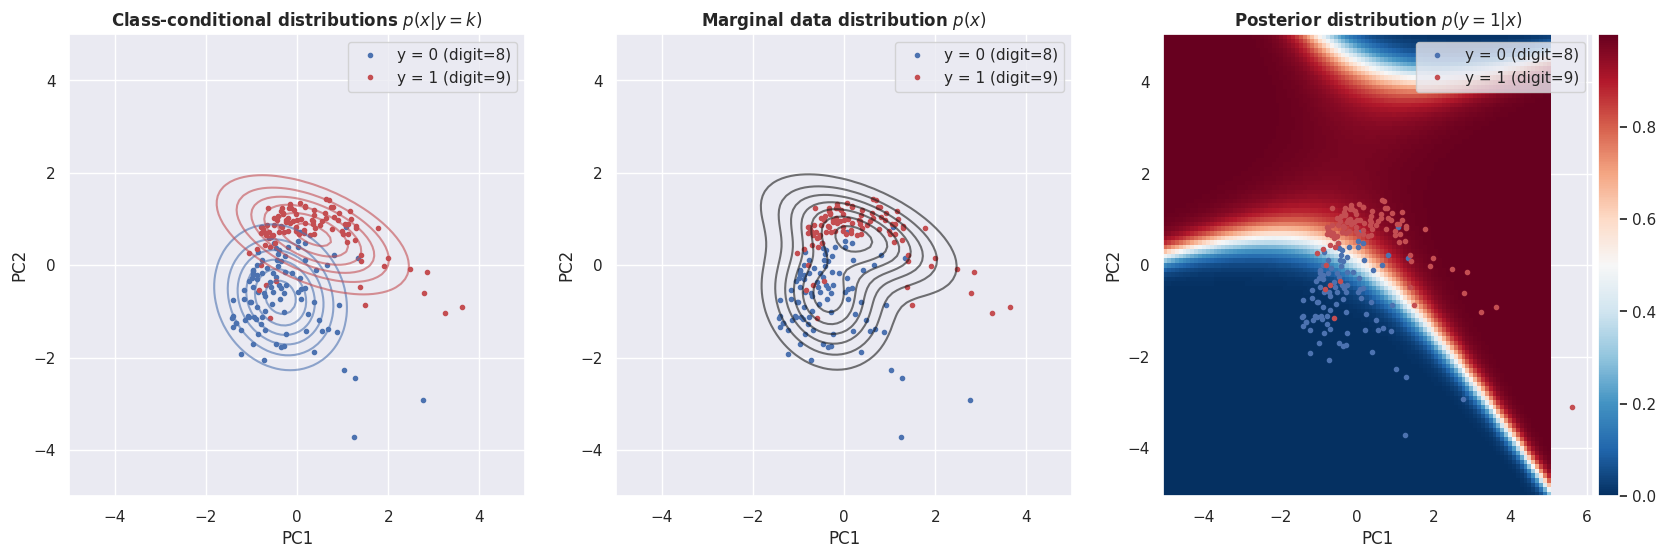

In [9]:
# evaluate posterior p(y=1|x) on every pair of grid points
post_grid = eval_density_grid(posterior_y1, dim1_array, dim2_array)

# prep plot
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# plot data
for i in range(3):
    plot_data(ax[i], Xtrain, ytrain, title='Training set')

# plot class-conditionals
plot_distribution(ax[0], dim1_array, dim2_array, log_p_x_given_y0, color='b', alpha=0.6, label='$p(x|y=0)$')
plot_distribution(ax[0], dim1_array, dim2_array, log_p_x_given_y1, color='r', alpha=0.6, label='$p(x|y=1)$')
ax[0].set_title('Class-conditional distributions $p(x|y=k)$', fontweight='bold')

# plot marginal data dist
plot_distribution(ax[1], dim1_array, dim2_array, log_marginal, color='k', alpha=0.6, label='$p(x)$')
ax[1].set_title('Marginal data distribution $p(x)$', fontweight='bold')

# plot posterior
im = ax[2].pcolormesh(dim1_array, dim2_array, post_grid.T, cmap=plt.cm.RdBu_r, shading='auto')
ax[2].set_title('Posterior distribution $p(y=1|x)$', fontweight='bold');
add_colorbar(im, fig, ax[2])

**End of solution**

We will use the **accuracy** and **ELPD** (expected log predictive density) to quantify the performance of the classifier is given by

$$
\begin{align}
\text{ELPD}(\textbf{y}^*, \textbf{p}^*) = \frac{1}{M} \sum_{i=1}^M \log \left(\text{Ber}(y^*_i|p^*_i)\right),
\end{align}
$$

where $\textbf{y}^*$ in this case is the vector of ground truth values and $\textbf{p} ^*$ is a vector of predictive probabilities, i.e. $p^*_i = p(y^*_i=1|\textbf{x}^*_i)$. Accuracy only measures how often we are correct and incorrect, whereas the ELPD also takes in uncertainty into account. For both metrics, larger values are better.


In [10]:
# function for evaluating accuracy
def accuracy(y_true, p_hat, threshold=0.5):
    return jnp.mean(y_true.ravel() == 1.0*(p_hat.ravel() > threshold))


# function for evaluating the ELPD
def elpd(y_true, p_hat):
    return jnp.mean(binom_dist.logpmf(y_true.ravel(), n=1, p=p_hat.ravel()))

# example
y_example = jnp.array([1, 1, 0, 0, 0])
p_example1 = jnp.array([0.95, 0.95, 0.95, 0.95, 0.1])
p_example2 = jnp.array([0.95, 0.95, 0.51, 0.51, 0.1])

print(f' Acc(y, p1) =  {accuracy(y_example, p_example1):3.2f}')
print(f' Acc(y, p2) =  {accuracy(y_example, p_example2):3.2f}')
print(f'ELPD(y, p1) = {elpd(y_example, p_example1):3.2f}')
print(f'ELPD(y, p2) = {elpd(y_example, p_example2):3.2f}')


 Acc(y, p1) =  0.60
 Acc(y, p2) =  0.60
ELPD(y, p1) = -1.24
ELPD(y, p2) = -0.33


We can now evaluate the accuracy and ELPD for the training set and test set:

In [11]:
metrics = {'Accuracy': accuracy, 'ELPD': elpd}

# computer posterior probabilities for traning and test set
p_train_hat = posterior_y1(Xtrain)
p_test_hat = posterior_y1(Xtest)

print(40*'*')
print(f'Metric\t\tTraining\tTest')
print(40*'*')
for metric_name, metric_fun in metrics.items():
    print(f'{metric_name:15s}\t{metric_fun(ytrain, p_train_hat):+3.2f}\t\t{metric_fun(ytest, p_test_hat):+3.2f}')


****************************************
Metric		Training	Test
****************************************
Accuracy       	+0.89		+0.90
ELPD           	-0.31		-0.40


The concludes the part on **generative modelling**.

# Part 2:  Understanding the Laplace approximations

Before we can study the **discriminative approach** for classification, we first need to study the **Laplace approximation** because this will be our main workhorse for (approximate) posterior inference. To gain some intuition, we will first study the Laplace approximation in the context of a model we already now and understand, the Beta-binomial model, which is given by

$$\begin{align*}
y|\theta &\sim \text{Bin}(N, \theta),\\
\theta &\sim \text{Beta}(\alpha_0, \beta_0)
\end{align*}
$$

with joint distribution $p(y, \theta) = p(y|\theta)p(\theta)$ and $\alpha_0, \beta_0 > 0$ are fixed hyperparameters. For this specific model, we already know that the true posterior of $\theta$ is another Beta distribution given by

$$\begin{align*}
p(\theta|y) = \text{Beta}(\theta|\alpha_0 + y, \beta_0 + N -y).
\end{align*}$$

Hence, we can approximate $p(\theta|y)$ with a Laplace approximation $q(\theta) = \mathcal{N}(\theta|\textbf{m}, \textbf{V})$ and the study the accuracy of the $q(\theta)$ by comparing it to the true solution $p(\theta|y)$.
Recall, the Laplace approximation is obtained by making a second order Taylor approximation of the log joint distribution, i.e. $f(\theta) = \log p(\theta, y)$, around the mode, i.e. $\theta_{\text{MAP}} = \arg\max_{\theta} p(\theta|y)$:

$$\begin{align*}
f(\theta) \approx f(\theta_{\text{MAP}}) - \frac{1}{2}(\theta-\theta_{\text{MAP}})A(\theta - \theta_{\text{MAP}})
\end{align*}
$$

leading to the Laplace approximation

$$\begin{align*}
p(\theta|y) \approx q(\theta) = \mathcal{N}(\theta|\theta_{\text{MAP}}, A^{-1}),
\end{align*}$$

where $A$ is the **negative** second order derivative of $f(\theta)$.

Hence, to set-up the Laplace approximation, our first order of business is to get a handle on the joint distribution:

$$\begin{align*}
p(y, \theta) = p(y|\theta)p(\theta).
\end{align*}$$

**Task 2.1**: Show that the log joint distribution is given by $\ln p(y, \theta) = (\alpha_0 + y - 1)  \ln \theta +  (\beta_0 + N-y -1)\ln (1-\theta) + \text{constant}$

**Solution**


Inserting the expression for the binomial distribution and the beta distribution and simplifying yields the desired result

$$
\begin{align*}
\ln p(y, \theta) &= \ln {N \choose y} \theta^y (1-\theta)^{N-y} + \ln \frac{1}{B(\alpha_0, \beta_0)}\theta^{\alpha_0-1}(1-\theta)^{\beta_0-1}\\
%
&= \ln {N \choose y} + y \ln \theta +  (N-y)\ln (1-\theta)-\ln B(\alpha_0, \beta_0) + (\alpha_0-1) \ln (\theta) + (\beta_0-1)\ln (1-\theta)\\
%
&= y \ln \theta +  (N-y)\ln (1-\theta)+ (\alpha_0-1) \ln \theta + (\beta_0-1)\ln (1-\theta) + k\\
%
&= (\alpha_0 + y - 1)  \ln \theta +  (\beta_0 + N-y -1)\ln (1-\theta) + k
\end{align*}
$$

**End of solution**


Our next job is to compute the first and second order derivatives:

**Task 2.2**: Show that the 1st and 2nd derivative of $\ln p(y, \theta)$ wrt. $\theta$ is given by 

$$\begin{align*}
\frac{\partial }{\partial \theta}\ln p(y, \theta) &= (\alpha_0 + y - 1)  \frac{1}{\theta} -(\beta_0 + N-y -1) \frac{1}{1-\theta}\\
\frac{\partial^2 }{\partial \theta^2}\ln p(y, \theta) &= -(\alpha_0 + y - 1) \frac{1}{\theta^2} -(\beta_0 + N-y -1) \frac{1}{(1-\theta)^2}
\end{align*}$$

**Solution**

Using $\frac{\partial }{\partial x} \log(x) = 1/x$ and the chain rule, we get the 1st derivative:

$$\begin{align*}
\frac{\partial }{\partial \theta}\ln p(y, \theta) &= (\alpha_0 + y - 1)  \frac{\partial }{\partial \theta} \ln \theta +  (\beta_0 + N-y -1) \frac{\partial }{\partial \theta}\ln (1-\theta)\\
%
\frac{\partial }{\partial \theta}\ln p(y, \theta) &= (\alpha_0 + y - 1) \frac{1}{\theta} +  (\beta_0 + N-y -1) \frac{1}{1-\theta} \frac{\partial }{\partial \theta}(1-\theta)\\
%
&= (\alpha_0 + y - 1)  \frac{1}{\theta} -(\beta_0 + N-y -1) \frac{1}{1-\theta}
\end{align*}
$$


Using $\frac{\partial}{\partial x} \frac{1}{x} = -\frac{1}{x^2}$, we get the 2nd order derivative
$$
\begin{align*}
\frac{\partial^2 }{\partial \theta^2}\ln p(y, \theta) &=  \frac{\partial }{\partial \theta}\left[(\alpha_0 + y - 1)  \frac{1}{\theta} -(\beta_0 + N-y -1) \frac{1}{1-\theta}\right]\\
%
&= (\alpha_0 + y - 1)  \frac{\partial }{\partial \theta}\frac{1}{\theta} -(\beta_0 + N-y -1) \frac{\partial }{\partial \theta}\frac{1}{1-\theta}\\
%
&= -(\alpha_0 + y - 1)  \frac{1}{\theta^2} +(\beta_0 + N-y -1)\frac{1}{(1-\theta)^2} \frac{\partial }{\partial \theta}(1-\theta)\\
%
&= -(\alpha_0 + y - 1)  \frac{1}{\theta^2} -(\beta_0 + N-y -1)\frac{1}{(1-\theta)^2} 
\end{align*}
$$



**End of solution**

The class below implements functions for plotting exact posterior PDF as well as computing its mean and variance. Initially, we will assume $N = 12$ and $y=2$. It also contains incomplete functions for evaluating the log joint, the gradient, and hessian, which you are going to implement later. But first, let's plot the posterior density for our specific dataset.

The exact posterior mean is 0.214
The exact posterior variance is 0.011


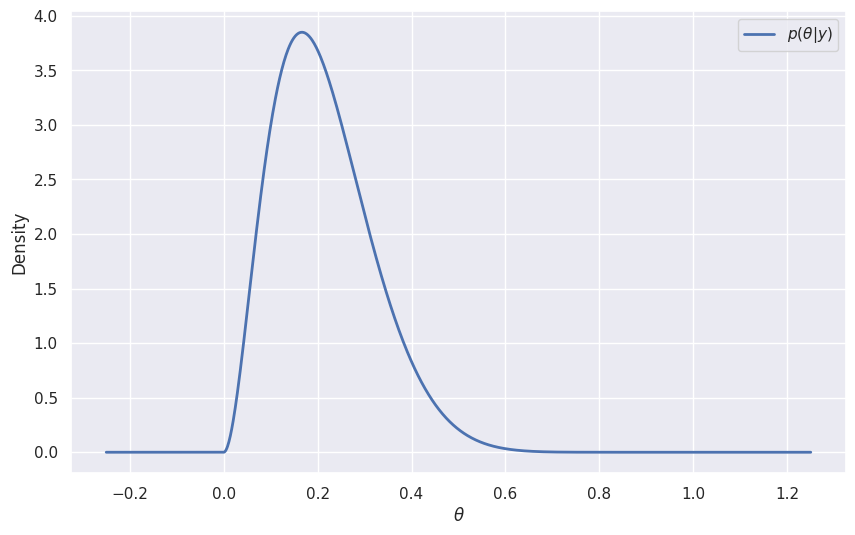

In [12]:
class BetaBinomial(object):

    def __init__(self, y, N, alpha0=1., beta0=1.):
        # data
        self.y, self.N = y, N
        # hyperparameters
        self.alpha0, self.beta0 = alpha0, beta0
        # true posterior parameters
        self.alpha, self.beta = alpha0 + y, beta0 + N - y

    @property
    def posterior_mean(self):
        """ compute the exact posterior mean """
        return self.alpha/(self.alpha + self.beta)
    
    @property
    def posterior_variance(self):
        """ compute the exact posterior variance """
        return self.alpha*self.beta/((self.alpha+self.beta)**2*(self.alpha+self.beta+1))

    def pdf(self, theta):
        return beta_dist.pdf(theta, self.alpha, self.beta)
    
    def log_joint(self, theta_):
        """ evaluates and return the log joint p(y, theta_) """
        return (self.alpha0 + self.y - 1)*jnp.log(theta_) + (self.beta0 + self.N - self.y - 1)*jnp.log(1-theta_) 

    def grad(self, theta_):
        """ evaluates and return the gradient of the log joint p(y, theta) write to theta evaluated at theta_ """
        return (self.alpha0 + self.y - 1)/theta_ - (self.beta0 + self.N - self.y - 1)/(1 - theta_) 

    def hessian(self, theta_):
        """ evaluates and return the hessian of the log joint p(y, theta) write to theta evaluated at theta_ """
        return -(self.alpha0 + self.y - 1)/theta_**2 - (self.beta0 + self.N - self.y - 1)/(1-theta_)**2 


# specify data and instantiate model
N = 12
y = 2
model = BetaBinomial(y, N)

# plot exact posterior density
theta_grid = jnp.linspace(-0.25, 1.25, 1000)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(theta_grid, model.pdf(theta_grid), label='$p(\\theta|y)$', linewidth=2)
ax.set(xlabel='$\\theta$', ylabel='Density')
ax.legend()

# report exact posterior mean and variance
print(f'The exact posterior mean is {model.posterior_mean:4.3f}')
print(f'The exact posterior variance is {model.posterior_variance:4.3f}')

**Task 2.3**: Go back up to the implementation of the class *BetaBinomial* and complete the implementation of the log joint as well as its gradient as hessian.

*Hints: The sanity below helps to verify your code. However, passing the test does not guarantee your code is correct.*

In [13]:
# sanity check of implementation
model = BetaBinomial(y=1, N=3, alpha0=1, beta0=1)
assert jnp.allclose(model.grad(1/4), 4/3), "Something appears to be wrong with your implementation of the gradient. Check your implementation."
assert jnp.allclose(model.grad(1/2), -2), "Something appears to be wrong with your implementation of the gradient. Check your implementation."
assert jnp.allclose(model.grad(3/4), -6.666666666666667), "Something appears to be wrong with your implementation of the gradient. Check your implementation."
assert jnp.allclose(model.hessian(1/4), -19.555555555555557), "Something appears to be wrong with your implementation of the hessian. Check your implementation."
assert jnp.allclose(model.hessian(1/2), -12), "Something appears to be wrong with your implementation of the hessian. Check your implementation."
assert jnp.allclose(model.hessian(3/4), -33.77777777777778), "Something appears to be wrong with your implementation of the hessian. Check your implementation."

If everything was implemented correctly, we can use almost any off-the-shelf optimizer for locating the mode of the posterior. We recommend using the *minimize* function from *scipy.optimize*. Note that our goal is to find the point that maximizes the posterior, whereas the *minimize*-function is designed for minimization and therefore, we need to flip the sign of the log_joint and its gradient when optimizing. Below we provide an example of how to use the optimizer in scipy:

In [14]:
# specify data and instantiate model
N = 12
y = 2
model = BetaBinomial(y, N)

# optimize
results = minimize(lambda x: -model.log_joint(x), jac= lambda x: -model.grad(x), x0=0.5, bounds=[(1e-10,1-1e-10)])

# print full results
print(results)

if results.success:
    print('Optimization succeded!\n')
    print(f'\tSolution: theta         = {results.x[0]:+4.3}')
    print(f'\t|gradient| at solution  = {results.jac[0]:+4.3e}')
else:
    print('Optimization failed. Check your implementation.')

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 5.406734506395656
        x: [ 1.667e-01]
      nit: 8
      jac: [-2.579e-09]
     nfev: 10
     njev: 10
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
Optimization succeded!

	Solution: theta         = +0.167
	|gradient| at solution  = -2.579e-09


Finally, we turn our attention to the Laplace approximation itself.

**Task 2.4**: Complete the LaplaceApproximation1D class below. You need to complete the following functions:  `construct_approximation`, `taylor_approx``, `pdf`.

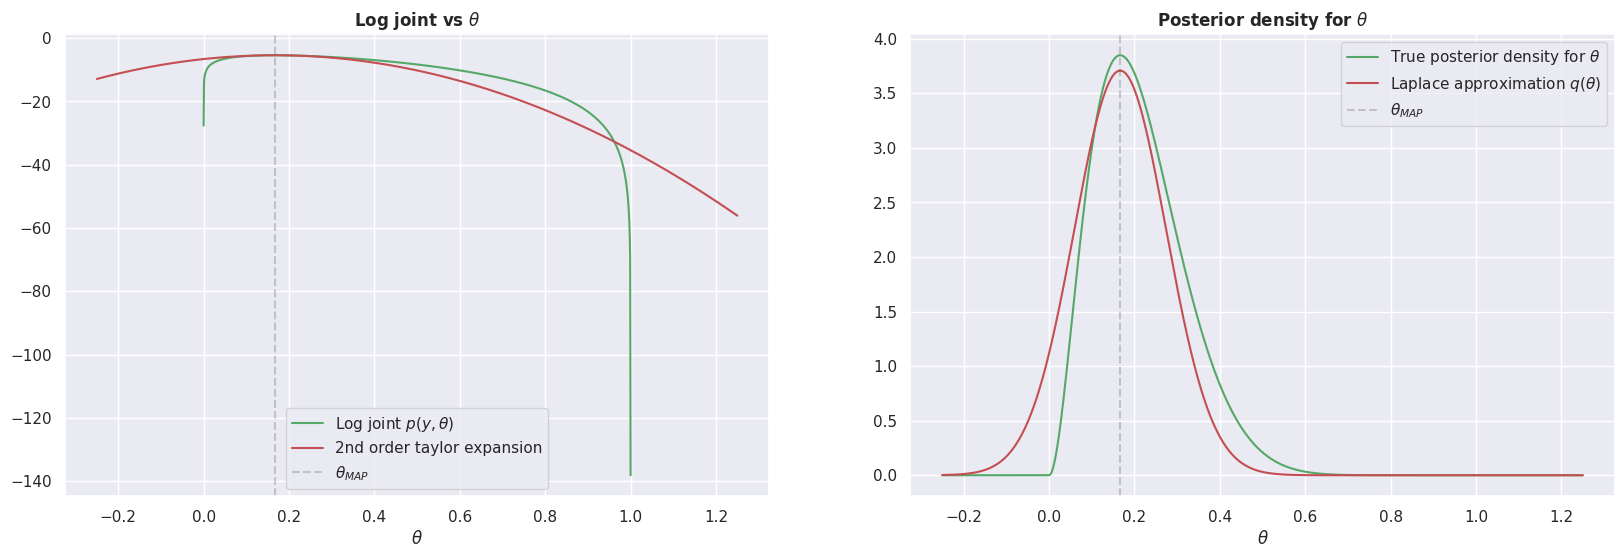

In [15]:
# helper functions implementing the pdf of a normal distribution
log_npdf = lambda x, m, v: -(x-m)**2/(2*v) - 0.5*jnp.log(2*jnp.pi*v)
npdf = lambda x, m, v: jnp.exp(log_npdf(x, m, v))

class LaplaceApproximation1D(object):

    def __init__(self, model, init_param=0):
        self.model = model
        self.param_MAP = None
        self.Hessian = None
        self.mean = None
        self.variance = None
        self.construct_approximation()

    def construct_approximation(self):

        # get MAP solution by optimization
        opt_results = minimize(lambda x: -self.model.log_joint(x), jac= lambda x: -self.model.grad(x), x0=0.5, bounds=[(1e-10,1-1e-10)])
        if not opt_results.success:
            print(opt_results)
            raise ValueError("Optimization failed. Printing the details from optimization for debugging")

        # evaluation Hessian at the mode
        self.param_MAP = opt_results.x                              
        self.Hessian = self.model.hessian(self.param_MAP)       
        self.mean = self.param_MAP                              
        self.variance = -1./self.Hessian                        

    def taylor_approx(self, theta):
        """" computes and returns the 2nd order Taylor approximation for f(theta) evalauted at theta """
        return self.model.log_joint(self.mean) + 0.5*self.Hessian*(self.mean-theta)**2 
        
    def pdf(self, theta):
        """ evaluates the PDF of the Laplace approximation q(theta) at input parameter value theta """
        return npdf(theta, self.mean, self.variance) 


# specify data and instantiate model
N = 12
y = 2
model = BetaBinomial(y, N)
laplace_approx = LaplaceApproximation1D(model)

# plot
fig, ax = plt.subplots(1,2, figsize=(20, 6))

theta_space_unit = jnp.linspace(1e-6, 1-1e-6, 1000)
theta_space = jnp.linspace(-0.25, 1.25, 1000)
ax[0].plot(theta_space_unit, model.log_joint(theta_space_unit), 'g', label='Log joint $p(y, \\theta)$')
ax[0].plot(theta_space, laplace_approx.taylor_approx(theta_space), color='r', label='2nd order taylor expansion')
ax[0].axvline(laplace_approx.mean, color='k', linestyle='--', alpha=0.2, label='$\\theta_{MAP}$')
ax[0].set(xlabel='$\\theta$')
ax[0].legend();
ax[0].set_title('Log joint vs $\\theta$', fontweight='bold');

ax[1].plot(theta_space, model.pdf(theta_space),  'g', label='True posterior density for $\\theta$')
ax[1].plot(theta_space, laplace_approx.pdf(theta_space), color='r', label='Laplace approximation $q(\\theta)$')
ax[1].axvline(laplace_approx.mean, color='k', linestyle='--', alpha=0.2, label='$\\theta_{MAP}$')
ax[1].set(xlabel='$\\theta$')
ax[1].legend();
ax[1].set_title('Posterior density for $\\theta$', fontweight='bold');

**Task 2.5**: How well does the Laplace approximation $q(\theta)$ resemble the true posterior? Experiment with different number of trials $N$ and successes $y$ and explore how the change affects the quality of the approximation. Try the following pairs $(y, N) \in \left\lbrace (1, 3), (10, 30), (10, 300), (1, 20) \right\rbrace$. Does the Laplace approximation 'respect' the domain of the parameter $\theta$?
 

# Part 3:  Implementing the logistic regression model

Equipped with the Laplace approximation, we will now turn our attention towards the Bayesian logistic regression model for binary classification. Recall, the model is defined as

$$\begin{align*}
y_n|\mathbf{w}, \mathbf{x}_n &\sim \text{Ber}(\sigma(f(\textbf{x}_n)))\\
\mathbf{w} &\sim \mathcal{N}(0, \alpha^{-1}\mathbf{I}),
\end{align*}$$

where $f(\textbf{x})$ is a linear model with parameters $\textbf{w}$ given by

$$\begin{align*}
f(\mathbf{x}) = \mathbf{w}^T \mathbf{x}.
\end{align*}
$$



Our goal for the exercise is two-fold: 1) we want to obtain the posterior distribution $p(\textbf{w}|\mathbf{y})$ to be able reason about the parameters in the linear model, and 2) we want to obtain the posterior predictive distribution $p(y^*|\textbf{y}, \textbf{x}^*)$ for a new input point $\textbf{x}^*$. Since logistic regression is a **non-conjugate** model, we need to resort to the Laplace approximation for approximate inference $p(\textbf{w}|\textbf{y}) \approx q(\textbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S})$.

First, we will write up the log joint distribution using the short-hand notation $f_n \equiv f(\mathbf{x}_n) = \mathbf{w}^T \mathbf{x}_n$:

$$\begin{align*}
\log p(\mathbf{y}, \mathbf{w}) &= \log p(\mathbf{y}|\mathbf{w}) + \log p(\mathbf{w})\\
&= \sum_{n=1}^N \log \text{Ber}(y_n|\sigma(f_n))+  \log \mathcal{N}(\mathbf{w}|0, \alpha^{-1}\mathbf{I})\\
&= \sum_{n=1}^N \left[(1-y_n)\log(1-\sigma(f_n)) + y_n\log(\sigma(f_n)) \right] - \frac{\alpha}{2}\mathbf{w}^T \mathbf{w} + \text{const.}
\end{align*}
$$

In order to implement the Laplace approximation, we need gradient and Hessian of the log joint distribution.
From this distribution, we can derive the gradient and Hessian. Calculating the gradient yields:

$$\begin{align*}
\nabla_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w}) &= \sum_{n=1}^N \left[(1-y_n)\nabla_{\mathbf{w}}\log(\sigma(-f_n)) + y_n\nabla_{\mathbf{w}}\log(\sigma(f_n)) \right] - \frac{\alpha}{2}\nabla_{\mathbf{w}}\mathbf{w}^T \mathbf{w} + \text{const.}\\
%
&= \sum_{n=1}^N \left[(1-y_n)\nabla_{\mathbf{w}}\log(\sigma(-f_n)) + y_n\nabla_{\mathbf{w}}\log(\sigma(f_n)) \right] - \alpha \mathbf{w} + \text{const.}
\end{align*}$$

By repeated use of the chain-rule, we evaluate the derivative of $\nabla_{\mathbf{w}}\log(\sigma(f_n))$

$$
\begin{align*}
\nabla_{\mathbf{w}}\log(\sigma(f_n)) &= \nabla_{\mathbf{w}} \log \frac{1}{1+e^{-f_n}} = -\nabla_{\mathbf{w}} \log (1+e^{-f_n})\\
&= - \frac{1}{1+e^{-f_n}} \nabla_{\mathbf{w}}\left(1+e^{-f_n}\right) \\
&= \frac{1}{1+e^{-f_n}}e^{-f_n} \nabla_{\mathbf{w}} f_n \\
&= \frac{1}{1+e^{-f_n}}e^{-f_n} \nabla_{\mathbf{w}} \bm{w}^T \mathbf{x}_n \\
&= \frac{e^{-f_n}}{1+e^{-f_n}}\mathbf{x}_n \\
&= \left[1-\sigma(f_n)\right]\mathbf{x}_n \\
\end{align*}
$$

and a similar line of calculations yields

$$
\begin{align*}
\nabla_{\mathbf{w}}\log(1-\sigma(f_n)) &=  -\sigma(f_n) \textbf{x}_n.
\end{align*}
$$

Substituting back into the expression yields:

$$\begin{align*}
\nabla_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w}) &= \sum_{n=1}^N \left[-(1-y_n)\sigma(f_n) \textbf{x}_n + y_n\left[1-\sigma(f_n)\right]\mathbf{x}_n\right] -\alpha \mathbf{w}\\
%
&= \sum_{n=1}^N \left[\sigma(f_n)+y_n\sigma(f_n) + y_n-y_n\sigma(f_n)\right]\mathbf{x}_n - \alpha \mathbf{w}\\
%
&= -\sum_{n=1}^N \left[\sigma(f_n) - y_n\right]\mathbf{x}_n - \alpha \mathbf{w}
\end{align*}$$

Finally, we compute the Hessian
$$\begin{align*}
\mathcal{H}(\textbf{w})_{ij} = \frac{\partial^2}{\partial w_i \partial w_j} \log p(\mathbf{y}, \mathbf{w}) &= \frac{\partial}{\partial w_i}  \left[ -\sum_{n=1}^N \left[\sigma(f_n) - y_n\right]\mathbf{x}_n - \alpha \mathbf{w}\right]_j\\
%
&= -\sum_{n=1}^N \frac{\partial}{\partial w_i} \left[\sigma(f_n) - y_n\right]x_{n,j} - \alpha  \delta_{ij}\\
%
&= -\sum_{n=1}^N  \frac{\partial}{\partial w_i}\sigma(f_n)x_{n,j} - \alpha \delta_{ij}\\
%
&= -\sum_{n=1}^N  (1-\sigma(f_n))\sigma(f_n)x_{n,i}x_{n,j} - \alpha  \delta_{ij}
\end{align*}$$
where $\delta_{ij}$ is **Kronecker's delta function** (not to be confused with Dirac's delta function):
$$\begin{align*}
\delta_{ij} = \begin{cases}1 & \text{if } i = j\\0&\text{otherwise}\end{cases}.

\end{align*}$$
Hence,
$$\begin{align*}
\mathcal{H}(\textbf{w}) = \nabla^2_{\textbf{w}} \log p(\mathbf{y}, \mathbf{w}) = -\sum_{n=1}^N (1-\sigma(f_n))\sigma(f_n) \textbf{x}_n\textbf{x}_n^T - \alpha \textbf{I} = -\textbf{X}^T\textbf{S}\textbf{X} - \alpha \textbf{I},
\end{align*}
$$

where $\textbf{S} \in \mathbb{R}^{N \times N}$ is a diagonal matrix with $S_{nn} = (1-\sigma(f_n))\sigma(f_n)$ and $\textbf{X} \in \mathbb{R}^{N \times D}$ is the design matrix such  that $\textbf{x}_n$ will be the $n$'th row of $\textbf{X}$.

Recall, sometimes we want to use a **feature transformation** $\phi(\textbf{x})$ to model non-linear dependencies, e.g. $\phi(\textbf{x}_n) = \begin{bmatrix} 1 & x_{n,1} & x_{n,2} & x_{n,1}^2 & x_{n,2}^2 \end{bmatrix}$ with $f(\mathbf{x}_n) = \mathbf{w}^T \phi(\mathbf{x}_n)$.


For plotting purpose, we will need a class for evaluating function on 2D grids. This is similar to the Grid2D-class used in exercise2, but now we have also equipped it with a function for plotting heatmaps.

In [16]:
class Grid2D(object):
    """ helper class for evaluating the function func on the grid defined by (dim1, dim2)"""

    def __init__(self, dim1, dim2, func, name="Grid2D"):
        self.dim1 = dim1
        self.dim2 = dim2
        self.grid_size = (len(self.dim1), len(self.dim2))
        self.dim1_grid, self.dim2_grid = jnp.meshgrid(dim1, dim2, indexing='ij')
        self.func = func
        self.name = name
        
        # evaluate function on each grid point
        params_flat= jnp.column_stack((self.dim1_grid.flatten(), self.dim2_grid.flatten()))
        self.values = self.func(params_flat).squeeze().reshape(self.grid_size)

    def plot_contours(self, ax, color='b', num_contours=10, f=lambda x: x, alpha=1.0, title=None):
        ax.contour(self.dim1, self.dim2, f(self.values).T, num_contours, colors=color, alpha=alpha)
        ax.set(xlabel='$w_1$', ylabel='$w_2$')
        ax.set_title(self.name, fontweight='bold')

    def plot_heatmap(self, ax, f=lambda x: x, clim=[0, 1], colorbar=False):
        img = ax.pcolormesh(self.dim1, self.dim2, f(self.values).T, cmap=plt.cm.RdBu_r, clim=clim)
        ax.set(xlabel='$w_1$', ylabel='$w_2$')
        ax.set_title(self.name, fontweight='bold')
        if colorbar:
            add_colorbar(img, ax.get_figure(), ax)

**Task 3.1**: Below you are given a template for a logistic regression implementation. Complete the implementation of the gradient and hessian using the equations above.

If the gradient is implemented correct, the cell below will locate the MAP solution using gradient-based optimization and plot the MAP solution on the of the contours of the posterior:

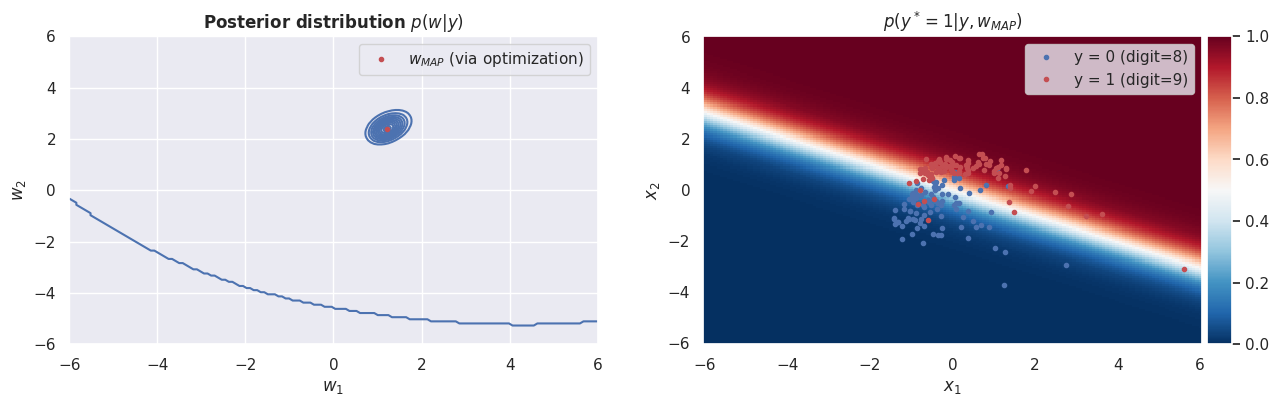

In [17]:
sigmoid = lambda x: 1./(1 + jnp.exp(-x))

class LogisticRegression(object):

    def __init__(self, X, y, feature_transformation=lambda x: x, alpha=1.):
        
        # store data and hyperparameters
        self.X0 = X
        self.y = y
        self.alpha = alpha
        self.feature_transformation = feature_transformation

        # apply feature transformation and standardize
        self.X = feature_transformation(self.X0)
        self.X_mean = jnp.mean(self.X, 0)
        self.X_std = jnp.std(self.X, 0)
        self.X_std.at[self.X_std == 0].set(1)
        self.X = self.preprocess(X)

        # store number of training data and number of features
        self.N, self.D = self.X.shape
        
        # get MAP by optimization
        self.w_MAP = self.get_MAP()

    def preprocess(self, X_):
        X = self.feature_transformation(X_)
        return (X - self.X_mean)/self.X_std
        
    def predict(self, X, w):
        """ evaluates sigma(f(X)) """
        f = w@X.T
        return sigmoid(f)
    
    def log_joint(self, w):
        """
            evaluates log joint, i.e. log p(y, w), for each row in w.
            w is expected to be of shape [M, D], where D is the number of parameters in the model and M is the number of points to evaluated
        """
        p = self.predict(self.X, w)
        log_prior = jnp.sum(log_npdf(w, 0, 1./self.alpha), axis=1)
        log_lik = binom_dist.logpmf(self.y, p=p, n=1)
        log_joint = log_prior + log_lik.sum(axis=1)

        return log_joint
    
    def hessian(self, w):
        """ Returns hessian of log joint evaluated at w 
            Input:   w       (shape: [1, D])
            Returns: H       (shape: [D, D])            """
        
        ##############################################
        # Your solution goes here
        ##############################################
        
        p = self.predict(self.X, w)
        v = p*(1-p)
        H = -self.X.T @ jnp.diag(v) @ self.X -self.alpha*jnp.identity(self.D)
        
        ##############################################
        # End of solution
        ##############################################
        
        assert H.shape == (self.D, self.D), f"The shape of the Hessians appears to be wrong. Expected shape ({self.D}, {self.D}), but received {H.shape}. Check your implementation"
        return H

    def grad(self, w):
        """ Returns gradient of log joint evaluated at w 
            Input:   w          (shape: [1, D])
            Returns: grad       (shape: [1, D])            """
        
        ##############################################
        # Your solution goes here
        ##############################################
        
        p = self.predict(self.X, w)
        err = p - self.y
        grad = -jnp.sum(err.T*self.X, axis=0) -self.alpha*w
        
        ##############################################
        # End of solution
        ##############################################

        assert grad.shape == (1, self.D), f"The shape of the gradient appears to be wrong. Expected shape (1, {self.D}), but received {grad.shape}. Check your implementation"
        return grad
  
    def get_MAP(self):
        """ returns MAP estimate obtained by maximizing the log joint """
        init_w = jnp.zeros(self.D)
        results = minimize(lambda x: -self.log_joint(x[None, :]), jac=lambda x: -self.grad(x[None, :]).flatten(), x0=init_w)
        if not results.success:
            print(results)
            raise ValueError('Optization failed')
        
        w_MAP = results.x 
        return w_MAP
    
        
# instantiate model
model = LogisticRegression(Xtrain, ytrain)

# function for making prediction using w_MAP point estimate
pred_MAP = lambda x: model.predict(model.preprocess(x), model.w_MAP)

# prep grid
dim1, dim2 = jnp.linspace(-6, 6, 150), jnp.linspace(-6, 6, 149)
grid_log_joint = Grid2D(dim1, dim2, model.log_joint, name='Posterior distribution $p(w|y)$')
grid_predictions = Grid2D(dim1, dim2, pred_MAP, name='$p(y^*=1|y, w_{MAP})$')

# plot
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
grid_log_joint.plot_contours(ax[0], f=jnp.exp,)
ax[0].plot(model.w_MAP[0], model.w_MAP[1], 'r.', label='$w_{MAP}$ (via optimization)')
ax[0].legend()

plot_data(ax[1], Xtrain, ytrain, 'Training data')
grid_predictions.plot_heatmap(ax[1], colorbar=True)
ax[1].set(xlabel='$x_1$', ylabel='$x_2$');

Using feature transformations, we can model non-linear decision boundaries, but we cannot easily visualize the posterior anymore (**why not?**):

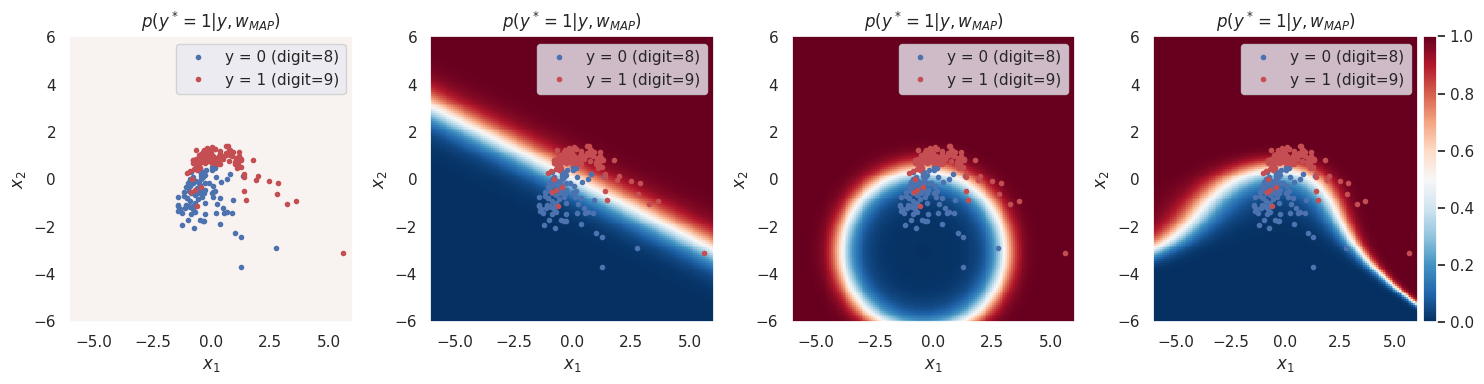

In [18]:
# simple polymials as feature transformation
def feature_transformation(x, order=1):
    return jnp.column_stack([x**m for m in range(order+1)])

# prep grid
dim1, dim2 = jnp.linspace(-6, 6, 150), jnp.linspace(-6, 6, 149)

# plot
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

for i in range(4):

    # instantiate model
    model = LogisticRegression(Xtrain, ytrain, feature_transformation=lambda x: feature_transformation(x, order=i))

    # function for making prediction using w_MAP point estimate
    pred_MAP = lambda x: model.predict(model.preprocess(x), model.w_MAP)

    # evaluate prediction for grid
    grid_predictions = Grid2D(dim1, dim2, pred_MAP, name='$p(y^*=1|y, w_{MAP})$')

    # plot
    plot_data(ax[i], Xtrain, ytrain, 'Training data')
    grid_predictions.plot_heatmap(ax[i], colorbar=True if i == 3 else False)
    ax[i].set(xlabel='$x_1$', ylabel='$x_2$')

fig.tight_layout()

# Part 4:  Implementing the Laplace approximation for logistic regression

We are now ready to implement the Laplace approximation. We have already done most of the hard word, now we simply need to combine all the pieces. For the purpose of validating our implementation, we will temporarily remove the feature transformation again.

**Task 4.1**: Complete the implementation the Laplace approximation below. To verify your implementation, we will generate 200 samples from the posterior, $\textbf{w}^i \sim q(\textbf{w})$ and the plot the samples on top of the contours of posterior distribution. You should expect to see samples covering the contours of the posterior distribution.

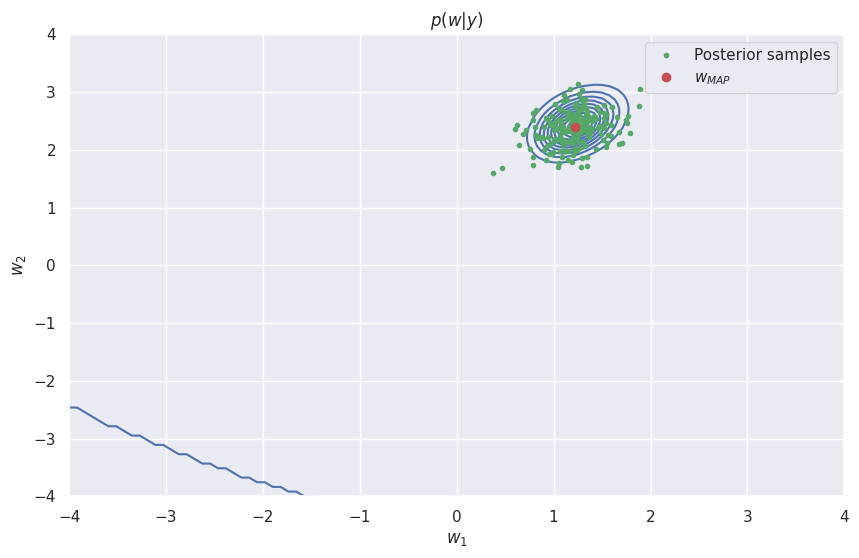

In [19]:
class LaplaceApproximation(object):

    def __init__(self, model):
        """ implements a laplace approximain q(w) = N(m, S), where m is the posterior mean and S is the posterior covariance """

        # store model
        self.model = model

        # implement Laplace approximation
        self.posterior_mean = model.w_MAP                               
        self.posterior_hessian = model.hessian(model.w_MAP)             
        self.posterior_cov = -jnp.linalg.inv(self.posterior_hessian)     

        # sanity check for dimensions
        assert self.posterior_mean.shape == (model.D,), f"The shape of the posterior mean appears wrong. Check your implementaion."
        assert self.posterior_hessian.shape == (model.D, model.D), f"The shape of the posterior Hessian appears wrong. Check your implementaion."
        assert self.posterior_cov.shape == (model.D, model.D), f"The shape of the posterior covariance appears wrong. Check your implementaion."

    def log_pdf(self, w):
        """ evaluate approximate posterior density at w """
        return mvn.logpdf(w, self.posterior_mean.ravel(), self.posterior_cov)
    
    def posterior_samples(self, key, num_samples):
        """ generate samples from posterior distribution """
        return random.multivariate_normal(key, self.posterior_mean, self.posterior_cov, shape=(num_samples, ))

# prep model and approximation
model = LogisticRegression(Xtrain, ytrain)
laplace = LaplaceApproximation(model)

# generate samples from posterior
key = random.PRNGKey(1)
w_samples = laplace.posterior_samples(key, 200)

# prep grid
dim1, dim2 = jnp.linspace(-4, 4, 100), jnp.linspace(-4, 4, 100)
grid_log_joint = Grid2D(dim1, dim2, model.log_joint, name='$p(w|y)$')

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
grid_log_joint.plot_contours(ax, f=jnp.exp)
ax.plot(w_samples[:, 0], w_samples[:, 1], 'g.', label='Posterior samples')
ax.plot(model.w_MAP[0], model.w_MAP[1], 'ro', label='$w_{MAP}$')
ax.legend();



**Task 4.2**: Report the (approximate) posterior mean and covariance of $p(\mathbf{w}|\mathbf{y})$

**Solution**

In [20]:
print(f'Posterior mean:\n{onp.array2string(laplace.posterior_mean, precision=2)}\n')
print(f'Posterior cov:\n{onp.array2string(laplace.posterior_cov, precision=2)}')

Posterior mean:
[1.22 2.4 ]

Posterior cov:
[[0.06 0.03]
 [0.03 0.09]]


**End of solution**

## Part 5:  Approximating the posterior predictive distribution

Now that we have obtained our Laplace approximation, i.e. $p(\textbf{w}|\textbf{y}) \approx q(\textbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S})$, it is finally time to make predictions. Our goal is to approximate the posterior predictive distribution $p(y^* = 1|\mathbf{y}, \mathbf{x}^*)$, which can be approximated as

$$\begin{align*}
p(y^*=1|\textbf{y}, \textbf{x}^*) = \int p(y^*=1|\textbf{w}, \textbf{x}^*) p(\textbf{w}|\textbf{y}) \text{d}\textbf{w} \approx \int p(y^*=1|\textbf{w}, \textbf{x}^*) q(\textbf{w}) \text{d}\textbf{w} = \int \sigma(\mathbf{w}^T \mathbf{x}^*) \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S}) \text{d} \mathbf{w} = \int \sigma(f^*) \mathcal{N}(f^*|m^*, v^*) \text{d} f^*,
\end{align*}$$

where $m^* = \mathbf{m}^T \mathbf{x} ^*$ and  and $v^* = (\mathbf{x}^*)^T  \mathbf{S} \mathbf{x}_*$. In this exercise, we will implement three options for approximating the above integral:

**The plug-in approximation**

The first option is the **plug-in** aproximation using $\mathbf{m} = \mathbf{w}_{\text{MAP}}$:

$$\begin{align*}
p(y^*=1|\textbf{y}, \textbf{x}^*) \approx \sigma(m^*)
\end{align*}$$

This option is simple and very fast, but the drawback is that it ignores any posterior uncertainty for $f^*$.

**The probit approximation**

The second approach we will consider is the so-called **probit** approximation:

$$\begin{align*}
p(y^*=1|\textbf{y}, \textbf{x}^*) \approx \int \sigma(f^*) \mathcal{N}(f^*|m^*, v^*) \text{d} f^* \approx \int \Phi(f^* \sqrt{\frac{\pi}{8}}) \mathcal{N}(f^*|m^*, v^*) \text{d} f^* = \Phi\left(\frac{m^*}{\sqrt{\frac{8}{\pi} + v^*}}\right),
\end{align*}$$

where $\Phi(\cdot): \mathbb{R} \rightarrow (0,1)$ is the CDF of a standardized Gaussian distribution. The option is also fast, but comes with a small bias.


**The Monte Carlo estimator**

The third and last option is a Monte Carlo estimator:

$$\begin{align*}
p(y^*=1|\textbf{y}, \textbf{x}^*) \approx \frac{1}{S} \sum_{i=1}^S \sigma(f^*_{(i)}), \quad \text{where} \quad f^*_{(i)} \sim \mathcal{N}(f^*|m^*, v^*) \quad \text{for} \quad i = 1, ..., S
\end{align*}$$

We can make this estimator as precise as we want by increasing the number of Monte Carlo samples $S$. Of course, there is a trade between precision and computational cost. 




**Task 5.1**: Complete the implementation of the functions `montecarlo` and `probit_approx` in the class below for computing the Monte Carlo estimator and the probit approximation, respectively.

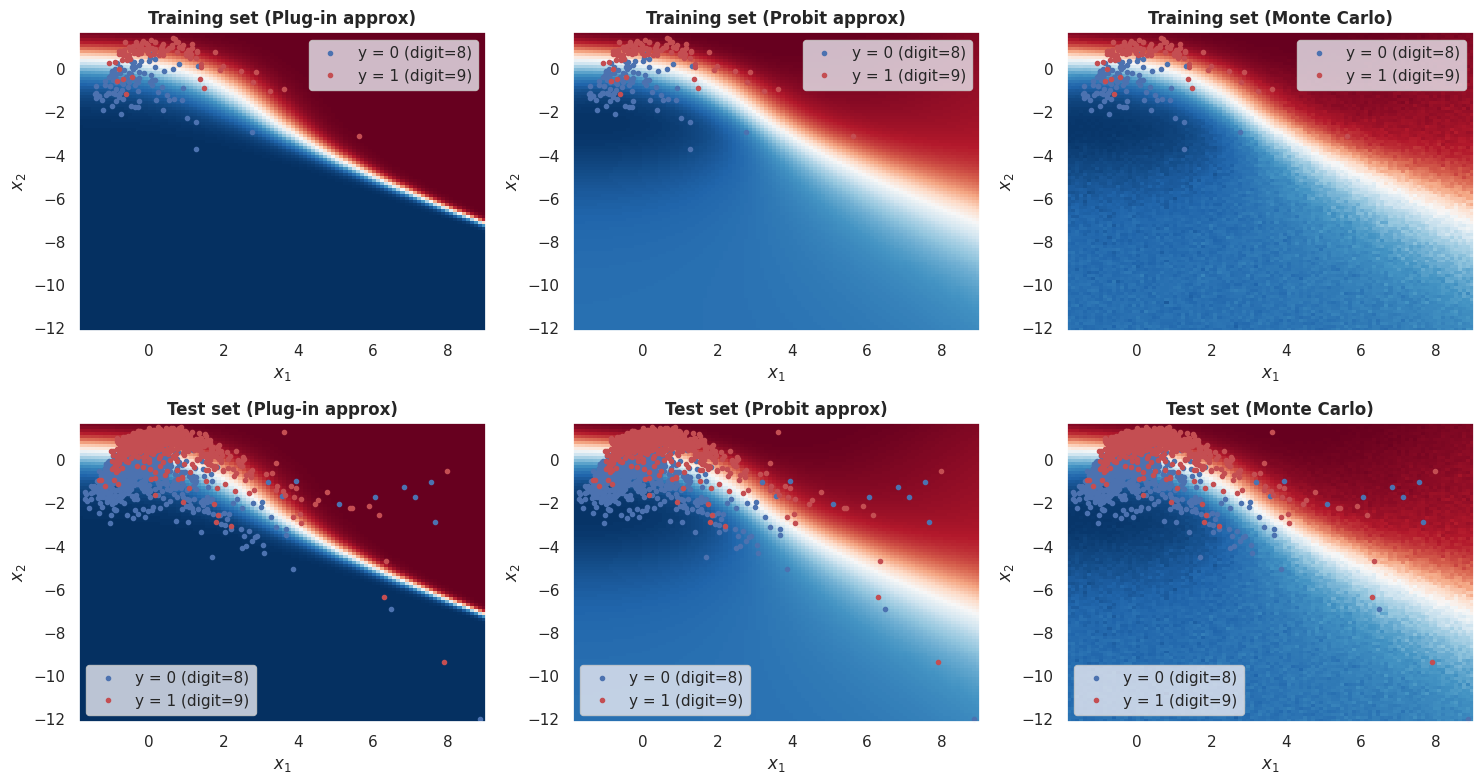

In [21]:
probit = lambda x: norm_dist.cdf(x)

class PosteriorPredictiveDistribution(object):
    
    def  __init__(self, model):
        self.model = model
        self.feature_transformation = model.feature_transformation
        self.laplace = LaplaceApproximation(model)

    def posterior_f(self, xstar_):
        """ computes the mean and variance of f^* = w^T x^* """
        xstar = self.model.preprocess(xstar_)
        m = xstar@self.laplace.posterior_mean
        v = jnp.diag(xstar@self.laplace.posterior_cov@xstar.T)
        return m, v

    def plugin_approx(self, xstar_):
        """ implements the plugin approximation for p(y^*|y, x^*) using w_MAP. If xstar has shape (M, D), then the shape of the output p must be (M,) """
        xstar = self.model.preprocess(xstar_)
        p = model.predict(xstar, model.w_MAP)

        assert p.shape == (len(xstar_),), f"Expected the shape of the output from the Monte Carlo approximation to be ({len(xstar)},), but the received shape was {p.shape}"
        return p
    
    def montecarlo(self, xstar, num_samples=1000, seed=0):
        """ implements the Monte Carlo estimator for p(y^*|y, x^*). If xstar has shape (M, D), then the shape of the output p must be (M,) """
        m, v = self.posterior_f(xstar)

        ##############################################
        # Your solution goes here
        ##############################################
        
        key = random.PRNGKey(seed)
        f = m  + jnp.sqrt(v)*random.normal(key, shape=(num_samples, len(xstar)))
        p = sigmoid(f).mean(0)
        
        ##############################################
        # End of solution
        ##############################################

        assert p.shape == (len(xstar),), f"Expected the shape of the output from the Monte Carlo approximation to be ({len(xstar)},), but the received shape was {p.shape}"
        return p

    def probit_approx(self, xstar):
        """ implements the probit approximation for p(y^*|y, x^*). If xstar has shape (M, D), then the shape of the output p must be (M,) """
        m, v = self.posterior_f(xstar)

        ##############################################
        # Your solution goes here
        ##############################################
        
        p = probit(m/jnp.sqrt(8/jnp.pi + v))
        
        ##############################################
        # End of solution
        ##############################################

        assert p.shape == (len(xstar),), f"Expected the shape of the output from the Monte Carlo approximation to be ({len(xstar)},), but the received shape was {p.shape}"
        return p
    
# simple polymials as feature transformation
def feature_transformation(x, order=1):
    return jnp.column_stack([x**m for m in range(order+1)])

# set up model and posterior predictive distribution
model = LogisticRegression(Xtrain, ytrain, feature_transformation=lambda x: feature_transformation(x, 3), alpha=5.)
postpred = PosteriorPredictiveDistribution(model)

pred_dict = {   'Plug-in approx': postpred.plugin_approx,
                'Probit approx':  postpred.probit_approx,
                'Monte Carlo':    postpred.montecarlo,
            }


dim1 = jnp.linspace(Xtest[:, 0].min()-0.1, Xtest[:, 0].max()+0.1, 100)
dim2 = jnp.linspace(Xtest[:, 1].min()-0.1, Xtest[:, 1].max()+0.1, 100)

fig, ax = plt.subplots(2, 3, figsize=(15, 8))
    
for i, (name, predict_func) in enumerate(pred_dict.items()):
    predict_grid = Grid2D(dim1, dim2, predict_func)

    plot_data(ax[0, i], Xtrain, ytrain, alpha=0.5)
    plot_data(ax[1, i], Xtest, ytest, alpha=0.5)
    predict_grid.plot_heatmap(ax[0, i])
    predict_grid.plot_heatmap(ax[1, i])
    ax[0, i].set_title(f'Training set ({name})', fontweight='bold')
    ax[1, i].set_title(f'Test set ({name})', fontweight='bold')
    ax[0, i].set(xlabel='$x_1$', ylabel='$x_2$')
    ax[1, i].set(xlabel='$x_1$', ylabel='$x_2$')


fig.tight_layout()




**Task 5.2**: Study the maps of the posterior predictive probability above and comment and the qualitative differences [**Discussion question**].

**Task 5.3**: Compute the training and test accuracy and ELPD for each of the three approximations:

*Hint: the ELPD may evaluate to -infinity for the plug-in approximation for numerical reasons. The problem is that we are first computing the predictive probability and then computing the ELPD. This is problematic when the predicted probabilities become either 0 or 1 to due to numerical underflow/overflow. However, this problem can be avoided by evaluating the ELPDs using the log probabilities instead.*

**Solution**

In [22]:
print(70*'*')
print(f'Method\t\t\tMetric\t\tTraining\tTest')
print(70*'*')
# loop over metrics
for metric_name, metric_fun in metrics.items():
    # loop over methods
    for method_name, predict_func in pred_dict.items():

        # make predictions for both training and test set
        p_train_hat = predict_func(Xtrain)
        p_test_hat = predict_func(Xtest)

        # print
        print(f'{method_name:24s}{metric_name:15s}\t{metric_fun(ytrain, p_train_hat):+3.2f}\t\t{metric_fun(ytest, p_test_hat):+3.2f}')
    print()

**********************************************************************
Method			Metric		Training	Test
**********************************************************************
Plug-in approx          Accuracy       	+0.90		+0.91
Probit approx           Accuracy       	+0.90		+0.91
Monte Carlo             Accuracy       	+0.90		+0.91

Plug-in approx          ELPD           	-0.29		-0.37
Probit approx           ELPD           	-0.29		-0.30
Monte Carlo             ELPD           	-0.30		-0.31



**End of solution**

# Part 6:  Insights into the posterior predictive distribution via the probit approximation

Besides being a very and accurate approximation of the posterior predictive distribution, we also use the probit approximation to gain insight into the behaviour of the model. The following task shows that if the posterior uncertainty of the parameters becomes sufficiently, i.e. $v^* = (\mathbf{x}^*)^T  \mathbf{S} \mathbf{x}_*$, then the posterior predictive distribution will be approach $\frac{1}{2}$.


**Task 6.1**: Show that the posterior predictive probability $p(y^*=1|\textbf{y}, \mathbf{x}) \rightarrow 0.5$ as the variance $v^* \rightarrow \infty$.

*Hints: What happens to $\frac{m^*}{\sqrt{\frac{8}{\pi} + v^*}}$ as $v^*$ increases?*

**Solution**

We have that

$$\begin{align*}
\lim_{v^* \rightarrow \infty} \frac{m^*}{\sqrt{\frac{8}{\pi} + v^*}} = 0
\end{align*}$$

Hence, since $\Phi(\cdot)$ is a continuous function, we have that

$$\begin{align*}
\lim_{v^* \rightarrow \infty} \Phi\left(\frac{m^*}{\sqrt{\frac{8}{\pi} + v^*}}\right) = 0.5
\end{align*}
$$



**End of solution**


**Task 6.2**: Show/argue that the plug-in approximation and the probit approximation generate the same **decisions** if we use the decision rule $y^* = \arg\max_{k} p(y^*=k|\textbf{y}, \textbf{x}^*)$.

**Solution**

For binary classification with the decision rule above, the decision boundary for the plugin approximation is given by $\sigma(\mathbf{m}^T \mathbf{x}^*) = 0.5 \iff \mathbf{m}^T \mathbf{x}^* = 0$. Hence, if the inner product $\mathbf{m}^T \mathbf{x}^*$ is positive, we assign $y^* = 1$ and vice versa.

Let's now look at the decision boundary for the probit approximation. We have 

$$\begin{align*}
\Phi\left(\frac{m^*}{\sqrt{\frac{8}{\pi} + v^*}}\right) = 0.5 \iff \frac{m^*}{\sqrt{\frac{8}{\pi} + v^*}} = \frac{\mathbf{m}^T \mathbf{x} ^*}{\sqrt{\frac{8}{\pi} + v^*}} = 0
\end{align*}$$

Now since the denominator is always positive, changing $v^*$ does not change the decision. It changes the probabilties, but not the decision. Hence, if the inner product $\mathbf{m}^T \mathbf{x}^*$ is positive, the probit approximation also assigns $y^* = 1$ and vice versa.

**End of solution**
